## notes
* weird behavior for input frequency in the ranges [978.6, 988.2] and [2303.4, 2313.0] MHz - data is extremely noisy regardless of actual signal
* input can only operate in 1st Nyquist zone (rolls off rapidly above 1.2 GHz) - might be able to change the coarse mixer?
* output PFB channels randomly have pi phase shifts (positive or negative amplitude) - should be possible to calibrate

In [1]:
# import sys
# sys.path.append('../qick/qick_lib/')

from mkids_4x1024 import *

import numpy as np

import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from scipy.signal import welch
from scipy.interpolate import interp1d
from tqdm.auto import tqdm


In [2]:
# Load bitstream with custom overlay
soc = TopSoc('./mkids_4x1024.bit', ignore_version=True, force_init_clks=True)

resetting clocks: 245.76 491.52


In [3]:
def round_freq(f): # in MHz
    df = soc.dds_out.DF_DDS
    return np.round(f/df)*df

In [4]:
#########################################
### Set output frequency with DDS+PFB ###
#########################################

def set_mixer(fmix): # fmix in MHz
    # Set mixer frequency.
    soc.pfb_out.set_fmix(fmix)
    return soc.pfb_out.get_fmix()

def freq2ch_out(freq, fmix):
    """return ch, dds_freq, center_freq
    """
    if isinstance(freq, list):
        freq = np.array(freq)
    fc = soc.pfb_out.fc
    ch, remainder = np.divmod(freq-fmix+fc/2,fc)
    return np.int64(ch)%soc.pfb_out.N, remainder-fc/2, fc*ch

def set_outputs(freqs, gains, equalize=True): # freqs in MHz
    # try to convert to float; if that fails, assume it's a list of floats
    try:
        gain_list = [float(gains)]*len(freqs)
    except TypeError:
        gain_list = gains
    assert len(freqs)==len(gain_list)
    
    if equalize:
        forward_freqs, forward_gains = np.load("output_gain.npy")
        # normalize to the minimum gain in the working band (which is +/- fb/2)
        # we're going to divide the output gain by this function, so we want the function to be always >=1
        # (otherwise we might exceed the output range)
        mingain = forward_gains[:(len(forward_gains)+1)//2].min()
        output_gain = interp1d(forward_freqs, forward_gains/mingain)
    
    # All channels off.
    soc.dds_out.alloff()
    pfb_chs, dds_freqs, _ = freq2ch_out(freqs, soc.pfb_out.get_fmix())
    
    for ch, fdds, gain in zip(pfb_chs, dds_freqs, gain_list):
        if equalize:
            equalized_gain = gain / output_gain(np.abs(fdds)/(soc.dds_out.FS_DDS))
        else:
            equalized_gain = gain
        soc.dds_out.ddscfg(f=fdds, g=equalized_gain, ch=ch)
        
    # Set the PFB quantization, which sets the PFB dynamic range.
    # 0 gives you max output power, larger values give you finer control
    soc.pfb_out.qout(0)


In [ ]:
soc.dds_out.alloff()


In [ ]:
set_mixer(1000) # MHz
fout = 500.3
set_outputs([fout], 0.1)

In [ ]:
set_mixer(1000) # MHz
fout = 500.3
set_outputs([fout], 0.00004) # minimum power

In [5]:
set_mixer(1000) # MHz
fout = 500.3 # MHz
set_outputs([fout], -1.0) # maximum power


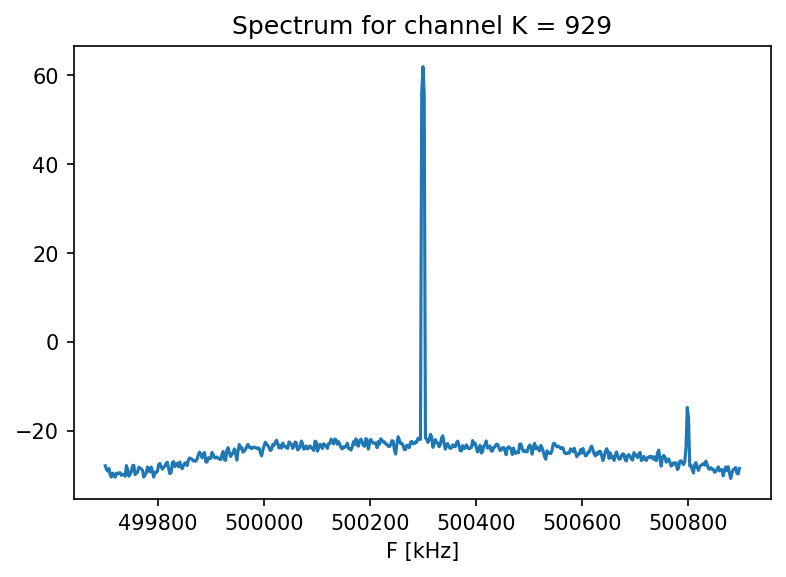

In [6]:
def freq2ch_in(freq):
    """return ch, dds_freq, center_freq
    """
    if isinstance(freq, list):
        freq = np.array(freq)
    fc = soc.pfb_in.fc
    n = soc.pfb_in.N
    ch, remainder = np.divmod(freq+fc/2,fc)
    return np.int64(ch+n//2)%n, remainder-fc/2, fc*ch

def measure_single(freq, decimation=2, downconvert=True): # MHz
    ###########################
    ### Plot single channel ###
    ###########################

    # Set the PFB quantization, which sets the PFB dynamic range.
    # this sets how many of the least significant bits are truncated, or something like that
    # larger values mean a given power will get converted to a smaller number of arbitrary units
    # the appropriate value depends on the signal strength
    # if you make this too small, your signal may overflow the range and you will see weird stuff:
    #     periodic sawtooth-y waveforms in the IQ data, lots of spurious spikes in the frequency spectrum
    # if you make this too big, your signal-to-noise ratio suffers (eventually your IQ values are all zero)
    # Values >=12 seem to be equivalent to 0
    soc.pfb_in.qout(7)
    
    # Set decimation value.
    # This also automatically sets the CIC quantization.
    soc.ddscic.decimation(value=decimation)

    # Channel's sampling frequency = bandwidth/decimation
    fs = soc.pfb_in.get_fb()/soc.ddscic.get_decimate()

#     rounded_freq = round_freq(freq)
    K, dds_freq, pfb_freq = freq2ch_in(freq)
    
    # Un-mask channel.
    soc.chsel.set_single(K)

    if downconvert:
        # Use DDS.
        soc.ddscic.dds_outsel(outsel="product")
        # Set DDS frequency.
#         dds_freq = (rounded_freq - pfb_freq)
        soc.ddscic.set_ddsfreq(ch_id=K, f=dds_freq)
        # need to correct by 1.0 if in "product" mode?
        offset = 1
        fcenter = pfb_freq+dds_freq
    else:
        # By-pass DDS product.
        soc.ddscic.dds_outsel(outsel="input")
        # need to correct offset, which depends on channel
        offset = 1.0 if K%2==0 else 0.5
        fcenter = pfb_freq

    # Transfer data.
    t_start = time.time()
    x_buf = soc.stream.get_data(idx=soc.chsel.ch2idx(K))
#     x_buf = soc.stream.get_data(nt=10, nsamp=1000,idx=soc.chsel.ch2idx(K))
#     print(time.time()-t_start)
    # nsamp * number of PFB channels * decimation / ADC sampling freq
    # example: 1e4*1024*250/2457.6e6 = ~1 sec
    return fs, fcenter, K, x_buf, offset

def plot_spectrum(fs, fcenter, K, x_buf, offset, truncate=200):
    # apply offset correction and convert to complex
    # TODO: figure out if there's a smarter way to get rid of junk at the start of the buffer
    x = (x_buf[truncate:].astype(np.float64)+offset).dot([1, 1j])

    plt.figure(1,dpi=150)

    F, Y = fftshift(welch(x,
                          fs*1000,
                          return_onesided=False,
                          detrend=False,
                          nperseg=512), axes=1)
    F += fcenter*1000
    plt.plot(F,10*np.log10(Y)) # welch gives you power spectrum

    plt.title("Spectrum for channel K = %d" %K);
    plt.xlabel("F [kHz]");

set_mixer(1000) # MHz
fout = 500.3
# fout = 982
# fout = 1500.3
# soc.dds_out.alloff()
# np.copyto(soc.stream.buff, 0)
set_outputs([fout], 0.1)
# fs, fcenter, K, x_buf, offset = measure_single(fout, downconvert=False)
fs, fcenter, K, x_buf, offset = measure_single(fout, downconvert=True)
plot_spectrum(fs, fcenter, K, x_buf, offset)

In [ ]:
plt.plot(x_buf[0:200])

In [ ]:
plt.plot(x_buf[200:])

In [7]:
# fmix = 0 # MHz
fmix = 1000 # MHz
fstart = 498
fstop = 503
truncate = 200

input_gain = interp1d(*np.load("input_gain.npy"))

set_mixer(fmix)
freqs = round_freq(np.linspace(fstart,fstop,201))
results = np.zeros((len(freqs),2))
for i, fout in enumerate(tqdm(freqs)):
    set_outputs([fout], 0.1, equalize=False)
    fs, fcenter, K, x_buf, offset = measure_single(fout, decimation=2, downconvert=True)
    results[i] = x_buf[truncate:].mean(axis=0)+offset
#     results[i] /= input_gain(np.abs((fout - soc.pfb_in.ch2freq(K))/soc.pfb_in.fb))
    
results_complex = results.dot([1,1j])

  0%|          | 0/201 [00:00<?, ?it/s]

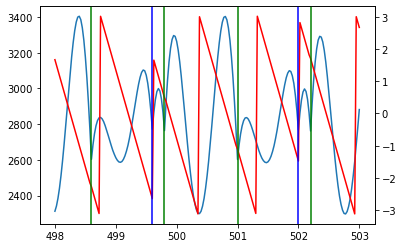

In [8]:
output_spacing = soc.pfb_out.fc
input_spacing = soc.pfb_in.fc
def edges(start, stop, spacing, offset=0):
    offset_phase = (0.5+offset/spacing)%1
    return spacing * np.arange(start/spacing + ((offset_phase - start/spacing) % 1), stop/spacing)

output_edges = edges(fstart, fstop, output_spacing, fmix%output_spacing)
input_edges = edges(fstart, fstop, input_spacing)

fig, ax1 = plt.subplots()

ax1.plot(freqs, np.abs(results_complex))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, np.angle(results_complex),color='red')

for f in output_edges:
    plt.axvline(f, color='blue')
for f in input_edges:
    plt.axvline(f, color='green')

In [ ]:
# fmix = 500 # MHz
# fstart = 10
# fstop = 1000
fmix = 1000 # MHz
fstart = 500
fstop = 1500
# fstart = 978
# fstop = 989
# fstart = 978.59
# fstop = 978.61
# fstart = 988.19
# fstop = 988.21
# fmix = 2500 # MHz
# fstart = 2000
# fstop = 3000
# fstart = 2303.39
# fstop = 2303.41
# fstart = 2312.99
# fstop = 2313.01

input_gain = interp1d(*np.load("input_gain.npy"))

set_mixer(fmix)
freqs = round_freq(np.linspace(fstart,fstop,201))
results = np.zeros((len(freqs),2))
for i, fout in enumerate(tqdm(freqs)):
    set_outputs([fout], 0.1)
    fs, fcenter, K, x_buf, offset = measure_single(fout, decimation=2, downconvert=True)
    results[i] = x_buf[truncate:].mean(axis=0)+offset

    pfb_freq = np.round(fout/soc.pfb_in.fc)*soc.pfb_in.fc
    results[i] /= input_gain(np.abs((fout - pfb_freq)/soc.pfb_in.fb))
    
results_complex = results.dot([1,1j])
plt.plot(freqs, np.abs(results_complex))

In [ ]:
plt.semilogy(freqs, np.abs(results_complex))

## calibrate PFB gains

In [ ]:
# measure the output gain as a function of PFB frequency offset
# we can keep the real freq fixed (so the input gain doesn't change), and sweep the mixer freq

# real freq
fout = 500 # MHz
fout = np.round(fout/soc.pfb_out.fc)*soc.pfb_out.fc
print(fout)

# mixer range
fstart = 0
fcenter = soc.pfb_out.fb*0.5
fstop = soc.pfb_out.fb

soc.pfb_out.qout(0)
# get K and PFB frequency, which don't change during the sweep
set_mixer(fcenter)
K = soc.pfb_out.freq2ch(fout)
pfb_freq = soc.pfb_out.ch2freq(K) # MHz

freqs = round_freq(np.linspace(fstart,fstop,513))[1:] # drop the first point
results = np.zeros((len(freqs),2))
for i, fmix in enumerate(tqdm(freqs)):
    set_mixer(fmix)

    soc.dds_out.alloff()
    fdds = round_freq(fout - fmix - pfb_freq)*1000*1000 # Hz
    soc.dds_out.ddscfg(f=fdds, g=0.1, ch=K)
    
    _, _, _, x_buf, offset = measure_single(fout, decimation=2, downconvert=True)
    results[i] = x_buf[truncate:].mean(axis=0)+offset
results_complex = results.dot([1,1j])
gains = np.abs(results_complex)
normalized_freqs = (freqs-fcenter)/soc.pfb_out.fb

In [ ]:
plt.plot(freqs, gains)
for i in [-0.25, 0.25]:
    plt.axvline(fcenter + soc.pfb_out.fb*(i), color='blue')

In [ ]:
# normalize and save
center = len(gains)//2 - 1
forward_gains = gains[center:]
backward_gains = gains[center::-1]
plt.plot(forward_gains[:-1]-backward_gains) # check symmetry
forward_gains[:-1] += backward_gains
forward_gains[:-1] *= 0.5
# print(forward)
forward_freqs = normalized_freqs[center:]
forward_gains /= forward_gains[0] # normalize to center frequency
np.save("output_gain.npy",np.stack([forward_freqs, forward_gains]))

In [ ]:
plt.semilogy(*np.load("output_gain.npy"))
plt.axvline(0.25) # maximum frequency offset in normal use

In [ ]:
# now that the output gain is equalized, we can measure the input gain

fmix = 0 # MHz

# real freq range
fstart = 500 # MHz
fstart = np.round(fstart/soc.pfb_in.fc)*soc.pfb_in.fc
print(fstart)
fcenter = fstart + soc.pfb_in.fb*0.5
fstop = fstart + soc.pfb_in.fb

soc.pfb_in.qout(7)
decimation = 2
soc.ddscic.decimation(value=decimation)
soc.ddscic.dds_outsel(outsel="product")

# Channel number.
K = soc.pfb_in.freq2ch(fcenter)
# center frequency of PFB channel
pfb_freq = soc.pfb_in.ch2freq(K)
# Un-mask channel.
soc.chsel.set_single(K)
# need to correct by 1.0 if in "product" mode?
offset = 1
truncate = 200

freqs = round_freq(np.linspace(fstart,fstop,513)[:-1]) # drop the last point
results = np.zeros((len(freqs),2))
for i, fout in enumerate(tqdm(freqs)):
    set_outputs([fout], 0.1)
    
    # Set DDS frequency.
    dds_freq = round_freq(fout - pfb_freq)*1000*1000
    soc.ddscic.set_ddsfreq(ch_id=K, f=dds_freq)

    # Transfer data.
    x_buf = soc.stream.get_data(nt=1,idx=soc.chsel.ch2idx(K))
    
    results[i] = x_buf[truncate:].mean(axis=0)+offset
    
results_complex = results.dot([1,1j])
gains = np.abs(results_complex)
normalized_freqs = (freqs-fcenter)/soc.pfb_in.fb

In [ ]:
plt.plot(freqs, gains)
for i in [-0.25, 0.25]:
    plt.axvline(fcenter + soc.pfb_in.fb*(i), color='blue')

In [ ]:
# normalize and save
center = len(gains)//2
forward_gains = gains[center:]
backward_gains = gains[center::-1]
plt.plot(backward_gains[:-1]-forward_gains) # check symmetry
backward_gains[:-1] += forward_gains
backward_gains[:-1] *= 0.5
backward_freqs = -1*normalized_freqs[center::-1]
backward_gains /= backward_gains[0] # normalize to center frequency
np.save("input_gain.npy",np.stack([backward_freqs, backward_gains]))

In [ ]:
plt.semilogy(*np.load("input_gain.npy"))
plt.axvline(0.25) # maximum frequency offset in normal use

## calibrate phase jumps

In [ ]:
def edges(start, stop, spacing, offset=0):
    offset_phase = (0.5+offset/spacing)%1
    return spacing * np.arange(start/spacing + ((offset_phase - start/spacing) % 1), stop/spacing)


In [ ]:
# measure the phase as a function of PFB frequency offset
# we must keep the mixer fixed, because the mixer is not phase-coherent

# fmix = 0 # MHz
fmix = round_freq(1000) # MHz
fstart = 498
fstop = 503
truncate = 200

output_spacing = soc.pfb_out.fc
input_spacing = soc.pfb_in.fc
output_edges = edges(fstart, fstop, output_spacing, fmix%output_spacing)
input_edges = edges(fstart, fstop, input_spacing)

input_gain = interp1d(*np.load("input_gain.npy"))

set_mixer(fmix)
freqs = round_freq(np.linspace(fstart,fstop,201))
# freqs = round_freq(np.concatenate([[f-eps, f+eps] for f in np.concatenate([output_edges, input_edges])]))
# freqs.sort()
results = np.zeros((len(freqs),2))
for i, fout in enumerate(tqdm(freqs)):
    set_outputs([fout], 0.1)
    fs, fcenter, K, x_buf, offset = measure_single(fout, decimation=2, downconvert=True)
    results[i] = x_buf[truncate:].mean(axis=0)+offset
    results[i] /= input_gain(np.abs((fout - soc.pfb_in.ch2freq(K))/soc.pfb_in.fb))
    
results_complex = results.dot([1,1j])

phases = np.angle(results_complex)
plt.plot(freqs, phases)
# fig, ax1 = plt.subplots()

# ax1.plot(freqs, np.abs(results_complex))

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(freqs, np.angle(results_complex),color='red')
for f in output_edges:
    plt.axvline(f, color='blue')
for f in input_edges:
    plt.axvline(f, color='green')

In [ ]:
eps = 0.001

fmix = round_freq(1000) # MHz
fstart = 400
fstop = 600
truncate = 200

output_spacing = soc.pfb_out.fc
input_spacing = soc.pfb_in.fc
output_edges = edges(fstart, fstop, output_spacing, fmix%output_spacing)
input_edges = edges(fstart, fstop, input_spacing)

set_mixer(fmix)

results = np.zeros((len(output_edges), 2))
for i, fout in enumerate(tqdm(output_edges)):
    for j, delta in enumerate([-eps, eps]):
        f = round_freq(fout+delta)
        set_outputs([f], 0.1)
        _, _, _, x_buf, offset = measure_single(f, decimation=2, downconvert=True)
        phase = np.angle((x_buf[truncate:].mean(axis=0)+offset).dot([1,1j]))
        results[i,j] = phase
# print(results)

In [ ]:
(results[:,1]-results[:,0])%(2*np.pi)

In [ ]:
eps = 0.001

fmix = round_freq(1000) # MHz
fstart = 400
fstop = 600
truncate = 200

output_spacing = soc.pfb_out.fc
input_spacing = soc.pfb_in.fc
output_edges = edges(fstart, fstop, output_spacing, fmix%output_spacing)
input_edges = edges(fstart, fstop, input_spacing)

set_mixer(fmix)

results = np.zeros((len(input_edges), 2))
for i, fout in enumerate(tqdm(input_edges)):
    for j, delta in enumerate([-eps, eps]):
        f = round_freq(fout+delta)
        set_outputs([f], 0.1)
        _, _, _, x_buf, offset = measure_single(f, decimation=2, downconvert=True)
        phase = np.angle((x_buf[truncate:].mean(axis=0)+offset).dot([1,1j]))
        results[i,j] = phase
# print(results)

In [ ]:
(results[:,1]-results[:,0])%(2*np.pi)

In [ ]:
from scipy.optimize import least_squares

def wrap_phase(phases):
    """take an angle and fold it into the range [-pi,pi)"""
    return ((phases+np.pi) % (2*np.pi))-np.pi

def phase_residuals(data, prediction):
    """calculate residual between observed and predicted phases"""
    return wrap_phase(data-prediction)
    
def phase_model(x, freqs, fmix):
    """predicted phase shift"""
    offset, slope, output_step, input_step = x
    n_output_steps = freq2ch_out(freqs,fmix)[0]
    n_input_steps = freq2ch_in(freqs)[0]-soc.pfb_in.N//2
    
    phases = offset + slope*freqs + output_step*n_output_steps + input_step*n_input_steps
    return wrap_phase(phases)

def phase_func(x, freqs, phases, fmix):
    """residuals function to be minimized"""
    return phase_residuals(phases, phase_model(x, freqs, fmix))

def initial_guess(freqs, phases, fmix):
    dphase = phases[1:]-phases[:-1]
    dfreq = freqs[1:]-freqs[:-1]
    slopes = dphase/dfreq
    output_step = wrap_phase(dphase[-1])
    input_step = wrap_phase(dphase[(len(phases-1)//2)-1])
    slope = np.median(slopes)
    x0 = np.array([0.0, slope, output_step, input_step])
    x0[0] = np.median(phase_residuals(phases,phase_model(x0, freqs, fmix)))
    return x0

In [ ]:
# measure the phase as a function of PFB frequency offset
# we must keep the mixer fixed, because the mixer is not phase-coherent

eps = 0.001

fmix = 0 # MHz
fstart = 500 # MHz
# fmix_mod = fmix % soc.pfb_out.fc
# fstart = np.round((fstart-fmix_mod)/soc.pfb_out.fc)*soc.pfb_out.fc + fmix_mod
fstart = np.round((fstart)/soc.pfb_out.fc)*soc.pfb_out.fc
fstop = fstart + 0.5*soc.pfb_out.fc+eps
truncate = 200

set_mixer(fmix)
freqs = round_freq(np.linspace(fstart,fstop,21))
results = np.zeros((len(freqs),2))
for i, fout in enumerate(tqdm(freqs)):
    set_outputs([fout], 0.1)
    fs, fcenter, K, x_buf, offset = measure_single(fout, decimation=2, downconvert=True)
    results[i] = x_buf[truncate:].mean(axis=0)+offset
results_complex = results.dot([1,1j])

phases = np.angle(results_complex)
plt.plot(freqs, phases)
output_edges = edges(fstart, fstop, soc.pfb_out.fc, fmix%soc.pfb_out.fc)
input_edges = edges(fstart, fstop, soc.pfb_in.fc)
for f in output_edges:
    plt.axvline(f, color='blue')
for f in input_edges:
    plt.axvline(f, color='green')

In [ ]:
def initial_guess(freqs, phases, fmix):
    dphase = phases[1:]-phases[:-1]
    dfreq = freqs[1:]-freqs[:-1]
    slopes = dphase/dfreq
    output_step = wrap_phase(dphase[-1])
    input_step = wrap_phase(dphase[(len(phases-1)//2)-1])
    slope = np.median(slopes)
    x0 = np.array([0.0, slope, output_step, input_step])
    x0[0] = np.median(phase_residuals(phases,phase_model(x0, freqs, fmix)))
    return x0

In [ ]:
x0 = initial_guess(freqs, phases, fmix)

print("initial estimate: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(x0))
fit = least_squares(phase_func, x0, args=(freqs, phases, fmix))
# print(fit.status)
print("after minimization: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(fit.x))

fig, axs = plt.subplots(2)
plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs, phases, marker='.', linestyle="None",color="Red")
plot.plot(freqs, phase_model(x0, freqs, fmix))
plot.plot(freqs, phase_model(fit.x, freqs, fmix))

plot = axs[1]
plot.set_ylabel(r"residual (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs, phase_func(fit.x, freqs, phases, fmix), marker='.', linestyle="None",color="Red")

In [ ]:
fmix = 0 # MHz
fstart = 498 # MHz
fstop = 510
truncate = 200

fmix = set_mixer(fmix)
freqs = round_freq(np.linspace(fstart,fstop,101))
results = np.zeros((len(freqs),2))
for i, fout in enumerate(tqdm(freqs)):
    set_outputs([fout], 0.1)
    fs, fcenter, K, x_buf, offset = measure_single(fout, decimation=2, downconvert=True)
    results[i] = x_buf[truncate:].mean(axis=0)+offset
results_complex = results.dot([1,1j])

phases = np.angle(results_complex)
plt.plot(freqs, phases)
output_edges = edges(fstart, fstop, soc.pfb_out.fc, fmix%soc.pfb_out.fc)
input_edges = edges(fstart, fstop, soc.pfb_in.fc)
for f in output_edges:
    plt.axvline(f, color='blue')
for f in input_edges:
    plt.axvline(f, color='green')

In [ ]:
x0 = fit.x
print("initial estimate: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(x0))
fit = least_squares(phase_func, x0, args=(freqs, phases, fmix))
# print(fit.status)
print("after minimization: %.2f rad shift, %.3f rad/MHz slope, %.3f rad output step, %.3f rad input step"% tuple(fit.x))

fig, axs = plt.subplots(2)
plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs,phases, marker='.', linestyle="None",color="Red")
plot.plot(freqs, phase_model(x0, freqs, fmix))
plot.plot(freqs, phase_model(fit.x, freqs, fmix))

plot = axs[1]
plot.set_ylabel(r"residual (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs, phase_func(x0, freqs, phases, fmix), marker='.', linestyle="None",color="Blue")
plot.plot(freqs, phase_func(fit.x, freqs, phases, fmix), marker='.', linestyle="None",color="Red")

In [ ]:
fmix = 500 # MHz
# fmix = 997.6 # MHz
fstart = 10 # MHz
fstop = 1000
truncate = 200

fmix = set_mixer(fmix)
freqs = round_freq(np.linspace(fstart,fstop,501))
results = np.zeros((len(freqs),2))
for i, fout in enumerate(tqdm(freqs)):
    set_outputs([fout], 0.1)
    fs, fcenter, K, x_buf, offset = measure_single(fout, decimation=2, downconvert=True)
    results[i] = x_buf[truncate:].mean(axis=0)+offset
results_complex = results.dot([1,1j])

phases = np.angle(results_complex)
fig, axs = plt.subplots(2)
plot = axs[0]
plot.set_title(r"$\phi$ vs $f$")
plot.set_ylabel(r"$\phi$ (rad)")
plot.set_xlabel(r"$f$ (MHz)")
plot.plot(freqs,phases, marker='.', linestyle="None",color="Red")
# plot.plot(freqs, phase_model(x0, freqs, fmix))
plot.plot(freqs, phase_model(fit.x, freqs, fmix))

plot = axs[1]
plot.set_ylabel(r"residual (rad)")
plot.set_xlabel(r"$f$ (MHz)")
# plot.plot(freqs, phase_func(x0, freqs, phases, fmix), marker='.', linestyle="None",color="Blue")
plot.plot(freqs, phase_func(fit.x, freqs, phases, fmix), marker='.', linestyle="None",color="Red")



In [ ]:
input_gain = interp1d(*np.load("input_gain.npy"))
corrected_complex = results_complex*np.exp(-1j*phase_model(fit.x, freqs, fmix))
corrected_complex /= input_gain(np.abs(freq2ch_in(freqs)[1])/soc.pfb_in.fb)

plt.plot(freqs, np.real(corrected_complex))
plt.plot(freqs, np.imag(corrected_complex))

In [ ]:
def test_edge(i):
    print(freqs[i], phases[i], phase_model(fit.x, freqs[i], fmix))
    num, denom = freqs[i].as_integer_ratio()
#     print(((freqs[i]-fmix)/soc.pfb_out.fc)-0.5)
    nstep = np.round(((freqs[i]-fmix)/soc.pfb_out.fc)-0.5)
#     print(num - np.round(denom*(nstep*0.5)*soc.pfb_out.fc*denom))
#     print(freqs[i] - soc.pfb_out.fc*np.round(((freqs[i]-fmix)/soc.pfb_out.fc)-0.5))
#     print(freqs[i] - soc.pfb_out.fc*(np.round(((freqs[i]-fmix)/soc.pfb_out.fc)-0.5)))
#     print(soc.pfb_out.freq2ch(freqs[i]))
#     print(soc.pfb_in.freq2ch(freqs[i]))
    
    
    
    testfreqs = np.array([freqs[i]-0.000001, freqs[i], freqs[i]+0.00001])
    print(phase_model(fit.x, testfreqs, fmix))
    print(freq2ch_out(testfreqs,fmix)[0])
#     print(((testfreqs-fmix)/soc.pfb_out.fc)-0.5)
#     print(np.ceil((round_freq(testfreqs-fmix)/soc.pfb_out.fc)-0.5))
#     print(np.ceil(testfreqs/soc.pfb_out.fc - fmix/soc.pfb_out.fc - 0.5))
    
#     print(np.floor(((testfreqs-fmix)/soc.pfb_out.fc)+0.5))
test_edge(0)
test_edge(20)
test_edge(40)
test_edge(60)
test_edge(80)
test_edge(100)

In [ ]:
print(freqs[60])

In [ ]:
eps = 0.001

fmix = round_freq(0.5*soc.pfb_out.fc) # MHz
fstart = 400
fstop = 600
truncate = 200

output_spacing = soc.pfb_out.fc
input_spacing = soc.pfb_in.fc
def edges(start, stop, spacing, offset=0):
    offset_phase = (0.5+offset/spacing)%1
#     return spacing * np.arange(int(start/spacing - offset_phase)+offset_phase, stop/spacing)
    return spacing * np.arange(start/spacing + ((offset_phase - start/spacing) % 1), stop/spacing)

output_edges = edges(fstart, fstop, output_spacing, fmix%output_spacing)
input_edges = edges(fstart, fstop, input_spacing)

set_mixer(fmix)

results = np.zeros((len(input_edges), 2))
for i, fout in enumerate(tqdm(input_edges)):
    for j, delta in enumerate([-eps, eps]):
        f = round_freq(fout+delta)
        set_outputs([f], 0.1)
        _, _, _, x_buf, offset = measure_single(f, decimation=2, downconvert=True)
        phase = np.angle((x_buf[truncate:].mean(axis=0)+offset).dot([1,1j]))
        results[i,j] = phase
# print(results)

In [ ]:
soc.pfb_in.fc

In [ ]:
output_edges

In [ ]:
np.arange(2,5.5)

In [ ]:
print(soc.chsel.B) # 32 bits?
print(soc.chsel.L) # 8 channels per transaction?
print(soc.chsel.NCH) # 1024 channels
print(soc.chsel.NT) # NCH/L = 128 transactions per frame
print(soc.chsel.NM) # NM=NT/32, 4 memory locations with 32-bit bitmasks

In [ ]:
print(soc.stream.BAXIS) # 512 bits per AXIS transaction
print(soc.stream.NS_TR) # BAXIS/16 = 32 16-bit samples per AXIS transaction
print(soc.stream.NS) # NS_TR/2 = 16 data samples per AXIS transaction (data only in the lower half)
print(soc.stream.NI) # 1 index sample per transaction
print(soc.stream.NS_NI) # NS+NI = 17 useful samples per transaction

print(soc.stream.nsamp_reg) # configurable

# DMA buffer is nsamp*NS_TR*16-bit
# note that 16 data samples = 8 IQ pairs

In [ ]:
# DAC+ADC sampling freqs
print(soc.dacs)
print(soc.adcs)
# channel bandwidths and freq steps
print(soc.dds_out.FS_DDS) # Hz
print(soc.dds_out.DF_DDS) # Hz
print(soc.ddscic.FS_DDS) # Hz
print(soc.ddscic.DF_DDS) # Hz

In [ ]:
output_gain(0.1)

In [ ]:
import scipy.io
# f = scipy.io.loadmat('/home/xilinx/jupyter_notebooks/qick/firmware/ip/axis_pfb_readout_v2/src/matlab/base_h.fda')
m = scipy.io.loadmat('/home/xilinx/jupyter_notebooks/qick/firmware/ip/axis_pfb_readout_v2/src/matlab/base_h.mat')['Num'][0]

coeffs = np.round(m*2**17).astype(int)
freqs, response = scipy.signal.freqz(coeffs)
plt.plot(freqs, np.abs(response))
plt.xlim(0,1)

In [ ]:
print(coeffs)
print(coeffs[::8]) #7
print(coeffs[1::8])#5
print(coeffs[2::8])#3
print(coeffs[3::8])#1
print(coeffs[4::8])#6
print(coeffs[5::8])#4
print(coeffs[6::8])#2
print(coeffs[7::8])#0

In [ ]:
coeffs = []
coe_path = '/home/xilinx/jupyter_notebooks/qick/firmware/ip/axis_pfb_readout_v2/src/fir/coef/fir_'
for i, index in enumerate([7,5,3,1,6,4,2,0]):
    with open(coe_path + '%d.coe'%index) as f:
        f.readline() # skip radix
        line = f.readline()
        coeffs.append([int(s) for s in line.split()[2].split(',')])
# print(coeffs)
coeffs = np.stack(coeffs).T.flatten()

In [ ]:
coe_path = '/home/xilinx/jupyter_notebooks/cmb-fnal-rfsoc/mkids_4x4096_v4/firmware/ip/axis_pfbsynth_4x512_v1/src/fir/coef/fir_'
coeffs = []
# for i, index in enumerate([7,5,3,1,6,4,2,0]):
for i, index in enumerate(range(8)):
    with open(coe_path + '%d.coe'%index) as f:
        f.readline() # skip radix
        line = f.readline()
        coeffs.append([int(s) for s in line.split()[2].split(',')])
for i in range(8):
#     print(coeffs[i][18])
    plt.plot(coeffs[0][i::8])
    plt.plot(coeffs[1][i::8])

# for i in range(8):
#     print(coeffs[i][:20])
#     print(len(coeffs[i]))
    
#     plt.plot(coeffs[i][:20])
# print(coeffs)
# coeffs = np.stack(coeffs).T.flatten()
# plt.plot(coeffs[:100])

In [ ]:
m = scipy.io.loadmat('/home/xilinx/jupyter_notebooks/cmb-fnal-rfsoc/mkids_4x4096_v4/firmware/ip/axis_pfb_4x4096_v1/src/matlab/FirDesign-4096/hm.mat')['hm']
# print(m)
print(m.shape)
coeffs = m[0]

# coeffs = np.round(coeffs*2**17).astype(int)
print(len(coeffs))
# print(coeffs[:10])
# print(coeffs[-10:])

plt.plot(coeffs)
# print(np.mean(coeffs))
freqs, response = scipy.signal.freqz(coeffs)
# plt.semilogy(freqs, np.abs(response))

In [ ]:
m = scipy.io.loadmat('/home/xilinx/jupyter_notebooks/cmb-fnal-rfsoc/mkids_4x4096_v4/firmware/ip/axis_pfb_4x4096_v1/src/matlab/FirDesign-4096/h0.mat')['h0']
# print(m)
print(m.shape)
coeffs = m[0]

# coeffs = np.round(coeffs*2**17).astype(int)
print(len(coeffs))
# print(coeffs[:10])
# print(coeffs[-10:])

plt.plot(coeffs)
# print(np.mean(coeffs))
freqs, response = scipy.signal.freqz(coeffs)
# plt.semilogy(freqs, np.abs(response))

In [ ]:
m = scipy.io.loadmat('/home/xilinx/jupyter_notebooks/cmb-fnal-rfsoc/mkids_4x4096_v4/firmware/ip/axis_pfb_4x4096_v1/src/matlab/FirDesign-4096/h3.mat')['h3']
# print(m)
print(m.shape)
coeffs = m[0]

# coeffs = np.round(coeffs*2**17).astype(int)
print(len(coeffs))
# print(coeffs[:100])
# plt.plot(coeffs)
# print(np.mean(coeffs))
freqs, response = scipy.signal.freqz(coeffs[100:-100])
plt.semilogy(freqs, np.abs(response))
# plt.xlim(0,0.1)

In [ ]:
f = scipy.io.loadmat('/home/xilinx/jupyter_notebooks/cmb-fnal-rfsoc/mkids_4x4096_v4/firmware/ip/axis_pfb_4x4096_v1/src/matlab/FirDesign-4096/hm.fda')
print(f['s'])

In [ ]:
print(m)

In [ ]:
coeffs = np.round(m['Num'][0]*2**17).astype(int)
freqs, response = scipy.signal.freqz(coeffs)
plt.plot(freqs, np.abs(response))
plt.xlim(0,1)

In [ ]:
# m['Num']

plt.plot(m['Num'][0])


In [ ]:
plt.plot(np.abs(np.fft.rfft(m['Num'][0])))


In [ ]:
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta

# Several flavors of bandpass FIR filters.

def bandpass_firwin(ntaps, lowcut, highcut, fs, window='hamming'):
    nyq = 0.5 * fs
    taps = firwin(ntaps, [lowcut, highcut], nyq=nyq, pass_zero=False,
                  window=window, scale=False)
    return taps

In [ ]:
plt.plot(freqs[:-1], np.angle(results_complex[1:]) - np.angle(results_complex[:-1]),color='red')
for i in range(int(2*498.0/soc.pfb_in.fb), int(2*503.0/soc.pfb_in.fb)):
    plt.axvline(soc.pfb_in.fb*(i+0.5)/2, color='green')

for i in range(int(498.0/soc.pfb_in.fb), int(503.0/soc.pfb_in.fb)):
    plt.axvline(soc.pfb_in.fb*(i+0.5)+fmix % soc.pfb_in.fb, color='blue')
# plt.axvline(soc.pfb_in.fb*209.5)
# plt.axvline(soc.pfb_in.fb*208.25)


In [ ]:
fmix = 1000

In [ ]:
np.angle(results_complex[1:]) - np.angle(results_complex[:-1])

In [ ]:
print(soc.pfb_out.fb)
print(soc.pfb_in.fb)

In [ ]:
# plt.plot(x_buf[truncate:,0],x_buf[truncate:,1])
plt.plot(freqs,results)


In [ ]:
plt.plot(results[:,0],results[:,1])

In [ ]:
fs, fcenter, K, x_buf, offset = measure_single(fout, downconvert=False)
x_buf_all = soc.stream.get_all_data(nt=1)

first_K = 8*(K//8)
truncate = 200
plt.figure(1,dpi=150)
fcenter -= (K%8)*fs
for i in range(8):
    offset = 1.0 if i%2==0 else 0.5
    x = (x_buf_all[truncate:, 2*i:2*i+2].astype(np.float64)+offset).dot([1, 1j])
    
    F, Y = fftshift(welch(x,
                          fs*1000,
                          return_onesided=False,
                          detrend=False,
                          nperseg=512), axes=1)
    F += fcenter*1000
    plt.plot(F,10*np.log10(Y)) # welch gives you power spectrum
    fcenter += fs

plt.title("Spectrum for channels K = [%d,%d]" % (first_K, first_K+7));
plt.axvline(fout*1000)
plt.xlabel("F [kHz]");

In [ ]:
set_mixer(1000) # MHz
fout = 500.3 # MHz
set_outputs([fout], 0.1) # maximum power
fs, fcenter, K, x_buf, offset = measure_single(fout, downconvert=True)
print()


In [ ]:
print(x.mean())

In [ ]:
x.shape

In [ ]:
#############################
### Channels Side-by-Side ###
#############################
# Quantization.
soc.pfb_in.qout(7)

# Set Decimation value.
soc.ddscic.decimation(value=2)

# By-pass DDS product.
soc.ddscic.dds_outsel(outsel="input")

# Channel's sampling frequency.
fs = soc.pfb_in.get_fb()/soc.ddscic.get_decimate()

# Channels to plot.
#K = np.arange(soc.pfb_in.N)
#K = np.arange(80)
K = [403,404,405,406]

plt.figure(dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    #print("Iteration K = %d" %KK)
    fck = KK*soc.pfb_in.get_fc()
    
    # Un-mask channel.
    soc.chsel.set_single(KK)
    
    # Transfer data.
    x_buf = soc.stream.get_data(nt=1,idx=soc.chsel.ch2idx(KK),debug=False)
    x = x_buf.dot([1, 1j])
    
    # Frequency vector.
    F = (np.arange(len(x))/len(x)-0.5)*fs
    
    # Normalization factor.
    NF = (2**15)*len(F)

    w = np.hanning(len(x))
    xw = x*w
    YY = fftshift(fft(xw))
    YYlog = 20*np.log10(abs(YY)/NF)
    AA = np.concatenate((AA,YYlog))
    
    Fk = F+fck
    FF = np.concatenate((FF,Fk))
    plt.plot(Fk,YYlog)
    